# Hot Coffe Mod

## Business understanding

As programming students, our reliance on coffee is a well-known stereotype, especially during intense periods like exam weeks. This project stems from a personal and practical interest in understanding the real-world health implications of this habit. The primary objective is to analyze and model the impact of coffee consumption on key health and wellness indicators using the provided dataset. Rather than stopping at simple correlations, our goal is to determine whether coffee intake is a significant predictive factor for specific health outcomes, especially when compared to other lifestyle choices.

### Primary Goals

Our primary goal is to build a predictive model that can identify a caffeine threshold for negative health effects and determine its significance relative to other lifestyle factors.

The project will be successful if we can develop a machine learning model that accurately predicts a health outcome (like `Stress_Level` or `Sleep_Quality`) based on an individual's coffee consumption and other personal data.

1. **Determine a Caffeine Threshold**: Can we identify a daily `Caffeine_mg` threshold above which the probability of 'Poor' `Sleep_Quality` or 'High' `Stress_Level` significantly increases, holding other factors constant? **Logistic Regression?**

2. **Identify Key Health Predictors**: Which lifestyle habits— `Coffee_Intake`, `Alcohol_Consumption`, `Smoking`, or `Physical_Activity_Hours` —are the most significant predictors of `Health_Issues`? We will build a comprehensive model to predict the severity of these issues (`None`, `Mild`, `Moderate`, `Severe`) using a combination of all lifestyle factors. **Random Forests?**

### Secondary Goal

Our secondary goal is to investigate if the health impacts of coffee are particularly pronounced for our demographic. Specifically, we want to see if the problem will become worse for us after landing for an 'Office' job.

- **Predicting Stress by Occupation**: Can we accurately predict a person's `Stress_Level` based on their daily `Caffeine_mg`, `Sleep_Hours`, and `Occupation`? **Random Forests?**


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Set a nice style for the plots
sns.set_theme(style="whitegrid")

## Data understanding

*collect and explore the data.*
- *What data is available? What are the characteristics of the data (variable types, value distributions etc.)?*
- *Are there any quality issues with the data (missing values, outliers, nonsensical values)?*

### Features

| Column                    | Type        | Description                                                                 |
|---------------------------|-------------|-----------------------------------------------------------------------------|
| ID                        | Integer     | Unique record ID (1–10000)                                                 |
| Age                       | Integer     | Age of participant (18–80 years)                                           |
| Gender                    | Categorical | Male, Female, Other                                                        |
| Country                   | Categorical | Country of residence (20 countries)                                        |
| Coffee_Intake             | Float       | Daily coffee consumption in cups (0–10)                                    |
| Caffeine_mg               | Float       | Estimated daily caffeine intake in mg (1 cup ≈ 95 mg)                      |
| Sleep_Hours               | Float       | Average hours of sleep per night (3–10 hours)                              |
| Sleep_Quality             | Categorical | Poor, Fair, Good, Excellent (based on sleep hours)                         |
| BMI                       | Float       | Body Mass Index (15–40)                                                    |
| Heart_Rate                | Integer     | Resting heart rate (50–110 bpm)                                            |
| Stress_Level              | Categorical | Low, Medium, High (based on sleep hours and lifestyle)                     |
| Physical_Activity_Hours   | Float       | Weekly physical activity (0–15 hours)                                      |
| Health_Issues             | Categorical | None, Mild, Moderate, Severe (based on age, BMI, and sleep)                |
| Occupation                | Categorical | Office, Healthcare, Student, Service, Other                                |
| Smoking                   | Boolean     | 0 = No, 1 = Yes                                                            |
| Alcohol_Consumption       | Boolean     | 0 = No, 1 = Yes                                                            |


In [28]:
# Load the product group data
df = pd.read_csv('./coffee_data/synthetic_coffee_health_10000.csv')

# Display the first few rows of the dataframe
print("\n--- First 5 rows of the product dataset: ---\n")
display(df.head(5))


# Display the all relevant info in a transposed summary table
print("\n--- Product Data Summary Table --- \n")

# Create a DataFrame from the column names
features_summary_df = pd.DataFrame(df.columns, columns=['Feature'])

# Add columns for Data Type, Missing Values, and a list of Unique Values
features_summary_df['Data Type'] = df.dtypes.values
features_summary_df['Value Count'] = df.count().values
features_summary_df['Missing Values'] = df.isnull().sum().values
features_summary_df['Unique Values'] = [', '.join(map(str, df[col].unique())) for col in df.columns]

# Set the 'Feature' column as the index for cleaner presentation
features_summary_df.set_index('Feature', inplace=True)

display(features_summary_df)


--- First 5 rows of the product dataset: ---



,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1



--- Product Data Summary Table --- 



,Data Type,Value Count,Missing Values,Unique Values
Feature,,,,
ID,int64,10000,0,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,..."
Age,int64,10000,0,"40, 33, 42, 53, 32, 44, 29, 41, 37, 18, 28, 22..."
Gender,object,10000,0,"Male, Female, Other"
Country,object,10000,0,"Germany, Brazil, Spain, Mexico, France, Canada..."
Coffee_Intake,float64,10000,0,"3.5, 1.0, 5.3, 2.6, 3.1, 3.4, 2.7, 4.5, 1.7, 4..."
Caffeine_mg,float64,10000,0,"328.1, 94.1, 503.7, 249.2, 298.0, 326.4, 252.1..."
Sleep_Hours,float64,10000,0,"7.5, 6.2, 5.9, 7.3, 5.3, 6.4, 7.8, 5.5, 7.1, 8..."
Sleep_Quality,object,10000,0,"Good, Fair, Excellent, Poor"
BMI,float64,10000,0,"24.9, 20.0, 22.7, 24.7, 24.1, 27.0, 24.3, 15.8..."


## Data preparation

*data preprocessing*
- *cleaning the data*
- *transforming the data*
- *selecting the relevant features*


We might need to convert values to numerical - and adding new columns that will reflect same data but with numbers

In [29]:
# Create mapping dictionaries
stress_map = {'Low': 0, 'Medium': 1, 'High': 2}
sleep_map = {'Excellent': 0, 'Good': 1, 'Fair': 2, 'Poor': 3}
health_map = {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}


# Apply the mapping to create new numerical columns
df['Stress_Num'] = df['Stress_Level'].map(stress_map)
df['Sleep_Num'] = df['Sleep_Quality'].map(sleep_map)
df['Health_Num'] = df['Health_Issues'].map(health_map)

We are taking worth scenario and treat it as "bad life quality achievement" and mark it as 1 for logic regression to work with.

In [30]:
# --- Create three distinct binary targets ---
# Target 1: Is the person experiencing high stress?
df['Is_High_Stress'] = (df['Stress_Num'] >= 1).astype(int) # highest alternative 2
# Target 2: Is the person experiencing poor sleep?
df['Is_Poor_Sleep'] = (df['Sleep_Num'] >= 2).astype(int) # highest alternative 3
# Target 3: Does the person have any health issues ?
df['Has_Health_Issues'] = (df['Health_Num'] >= 1).astype(int) # highest alternative 2-3, two has been used on initial testings

print("Data Preparation Complete. New target columns created.")
df[['Stress_Level', 'Stress_Num', 'Is_High_Stress', 'Sleep_Quality', 'Sleep_Num',  'Is_Poor_Sleep', 'Health_Issues', 'Health_Num', 'Has_Health_Issues']].head()

Data Preparation Complete. New target columns created.


,Stress_Level,Stress_Num,Is_High_Stress,Sleep_Quality,Sleep_Num,Is_Poor_Sleep,Health_Issues,Health_Num,Has_Health_Issues
0,Low,0,0,Good,1,0,NaN,NaN,0
1,Low,0,0,Good,1,0,NaN,NaN,0
2,Medium,1,1,Fair,2,1,Mild,1.0,1
3,Low,0,0,Good,1,0,Mild,1.0,1
4,Medium,1,1,Fair,2,1,Mild,1.0,1


In [31]:
# hello

In [32]:
# world

In [33]:
# :)

## Modeling

*choose a machine learning method and train the model (+ model validation)*
- *which method was used?*
- *which parameters were used?*
- *what was the performance of the model?*


## Amount of Caffeine damaging the quality of life

We are creating three models for Sleep, Stress and Health overall to compare them and see the result

### Predicting High Stress

The goal is to predict the probability of having `Is_High_Stress` based solely on `Caffeine_mg`.

In [34]:
# --- Model for Stress ---
X = df[['Caffeine_mg']]
y_stress = df['Is_High_Stress']

# Split data for the stress model
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X, y_stress, test_size=0.3, random_state=42)

# Train the stress model
log_reg_stress = LogisticRegression(random_state=42)
log_reg_stress.fit(X_train_st, y_train_st)

# Generate predictions for plotting
caffeine_range = np.linspace(0, df['Caffeine_mg'].max(), 500).reshape(-1, 1)
# stress_probs = log_reg_stress.predict_proba(caffeine_range)[:, 1]
# Wrap caffeine_range in a DataFrame to match feature names and silence warning
caffeine_range_df = pd.DataFrame(caffeine_range, columns=['Caffeine_mg'])
stress_probs = log_reg_stress.predict_proba(caffeine_range_df)[:, 1]


# --- Find the highest probability and the tipping point for stress ---
max_stress_prob = stress_probs.max()
print(f"Maximum predicted probability for High Stress: {max_stress_prob:.2%}")

stress_tipping_point = None
try:
    tipping_point_index = np.where(stress_probs >= 0.5)[0][0]
    stress_tipping_point = caffeine_range[tipping_point_index][0]
    print(f"Tipping point for High Stress: ~{stress_tipping_point:.0f} mg")
except IndexError:
    print("Tipping point for High Stress was not found (probability never reached 50%).")

Maximum predicted probability for High Stress: 61.97%
Tipping point for High Stress: ~582 mg


### Predicting Poor Sleep

We build the second model to predict the probability of `Is_Poor_Sleep` based on `Caffeine_mg`.

In [35]:
# --- Model for Sleep ---
y_sleep = df['Is_Poor_Sleep']

# Split data for the sleep model
X_train_sl, X_test_sl, y_train_sl, y_test_sl = train_test_split(X, y_sleep, test_size=0.3, random_state=42)

# Train the sleep model
log_reg_sleep = LogisticRegression(random_state=42)
log_reg_sleep.fit(X_train_sl, y_train_sl)

# Generate predictions for plotting
# sleep_probs = log_reg_sleep.predict_proba(caffeine_range)[:, 1]
caffeine_range_df = pd.DataFrame(caffeine_range, columns=['Caffeine_mg'])
sleep_probs = log_reg_sleep.predict_proba(caffeine_range_df)[:, 1]


# --- Find the highest probability and the tipping point for sleep ---
max_sleep_prob = sleep_probs.max()
print(f"Maximum predicted probability for Poor Sleep: {max_sleep_prob:.2%}")

sleep_tipping_point = None
try:
    tipping_point_index = np.where(sleep_probs >= 0.5)[0][0]
    sleep_tipping_point = caffeine_range[tipping_point_index][0]
    print(f"Tipping point for Poor Sleep: ~{sleep_tipping_point:.0f} mg")
except IndexError:
    print("Tipping point for Poor Sleep was not found (probability never reached 50%).")

Maximum predicted probability for Poor Sleep: 61.97%
Tipping point for Poor Sleep: ~582 mg


### Predicting Health Issues

Finally, we build our third model to predict the probability of having any `Health_Issues` (Mild or worse) based on `Caffeine_mg`.

In [36]:
# --- Model for Health Issues ---
y_health = df['Has_Health_Issues']

# Split data for the health model
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X, y_health, test_size=0.3, random_state=42)

# Train the health model
log_reg_health = LogisticRegression(random_state=42)
log_reg_health.fit(X_train_h, y_train_h)

# Generate predictions for plotting
# health_probs = log_reg_health.predict_proba(caffeine_range)[:, 1]
caffeine_range_df = pd.DataFrame(caffeine_range, columns=['Caffeine_mg'])
health_probs = log_reg_health.predict_proba(caffeine_range_df)[:, 1]

# --- Find the highest probability and the tipping point for health ---
max_health_prob = health_probs.max()
print(f"Maximum predicted probability for Health Issues: {max_health_prob:.2%}")

health_tipping_point = None
try:
    tipping_point_index = np.where(health_probs >= 0.5)[0][0]
    health_tipping_point = caffeine_range[tipping_point_index][0]
    print(f"Tipping point for having Health Issues: ~{health_tipping_point:.0f} mg")
except IndexError:
    print("Tipping point for Health Issues was not found (probability never reached 50%).")

Maximum predicted probability for Health Issues: 64.10%
Tipping point for having Health Issues: ~450 mg


### Compare the results

By plotting all three probability curves on the same graph, we can visually compare them. The curve that rises fastest or has the lowest tipping point indicates the health aspect that is most sensitive to caffeine.

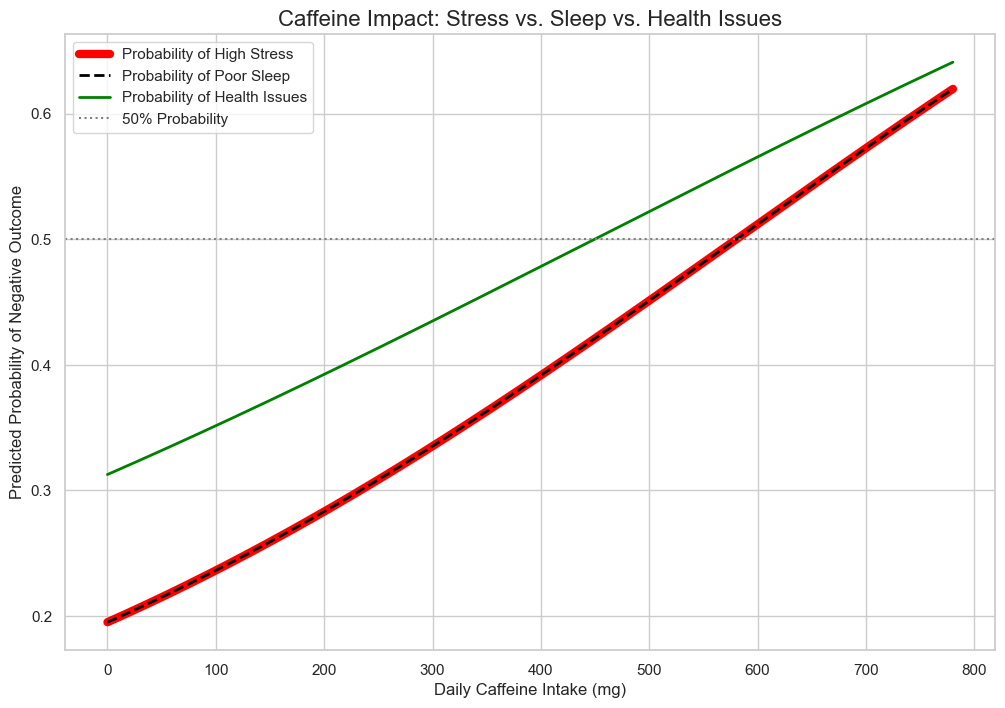

In [37]:
# --- Plotting All Three Curves for Comparison ---
plt.figure(figsize=(12, 8))

# Plot for Stress
plt.plot(caffeine_range, stress_probs, label='Probability of High Stress', color='red', linewidth=6)
# plt.axvline(x=stress_tipping_point, color='orange', linestyle='--', label=f'Stress Tipping Point (~{stress_tipping_point:.0f} mg)')

# Plot for Sleep
plt.plot(caffeine_range, sleep_probs, label='Probability of Poor Sleep', color='black', linestyle='--', linewidth=2)
# plt.axvline(x=sleep_tipping_point, color='purple', linestyle='--', label=f'Sleep Tipping Point (~{sleep_tipping_point:.0f} mg)')

# Plot for Health Issues
plt.plot(caffeine_range, health_probs, label='Probability of Health Issues', color='green', linewidth=2)
# plt.axvline(x=health_tipping_point, color='green', linestyle='--', label=f'Health Issues Tipping Point (~{health_tipping_point:.0f} mg)')


# Add reference line and labels
plt.axhline(y=0.5, color='grey', linestyle=':', label='50% Probability')
plt.title('Caffeine Impact: Stress vs. Sleep vs. Health Issues', fontsize=16)
plt.xlabel('Daily Caffeine Intake (mg)', fontsize=12)
plt.ylabel('Predicted Probability of Negative Outcome', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

So within 10 cups of coffee (or 1-2 energetics) you are somehow safe and there is no strong correlation between coffee and stress level. However, if you already had health issues coffee may make them worth and damage you beyond 50% probability. **Plot dependable on the input values**

## Evaluation

*evaluate the model*
- *How well does the model perform?*
- *Does it meet the business requirements?*


In [38]:
# hell world

## Deployment

johtopaatos / creating a recommendation of how to use the model in practice, or what to do next
- How will the model be used in practice?
- How will the results be communicated?

In [39]:
# hello world

### Reflection

#### Ai Usage
- for research

#### Team contribution
- who did what

#### Sources
- links & descriptions